In [ ]:
from google.colab import drive
# monta tu unidad de google drive
drive.mount('/content/drive')

# cambiamos el directorio de trabajo a la carpeta donde está almacenado el dataset
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/HomoMex_2024/public_data_dev_phase')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



CNN
Fragmento el dataset en training validacion test

In [ ]:
import pandas as pd

df_train = pd.read_csv("TrainT_concat.csv",  sep=',')
df_test = pd.read_csv("df_test_6_Df_original.csv",  sep=',')

print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

# mostramos los primeros registros del training:
df_train.head()



tamaño training: (10575, 2)
tamaño test: (420, 2)


,content,label
0,"@bi_cabron pues no te llega al estómago, sino...",NR
1,🚨 BREAKING NEWS 🚨\n\n⚧Gracias al litigio @Cher...,NP
2,Vamos MONTERREY!!!!!!! Queremos la Copa! La hi...,NR
3,Como disfruto a estas locas desde morritas ......,NR
4,Fans de #Transformers hoy voy a regalar pases ...,NR


Distribucion de las clases

In [ ]:
counts_train = df_train['label'].value_counts().to_dict()
print("Distribución en training:", counts_train)
counts_test = df_test['label'].value_counts().to_dict()
print("Distribución en test:", counts_test)


Distribución en training: {'NR': 3525, 'NP': 3525, 'P': 3525}
Distribución en test: {'NP': 261, 'NR': 107, 'P': 52}


<ipython-input-76-47cc4b87081f>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_train.set_xticklabels(list(counts_train.keys()), rotation=45)
<ipython-input-76-47cc4b87081f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_test.set_xticklabels(list(counts_test.keys()), rotation=45)


Text(0, 0.5, 'Número de Instancias')

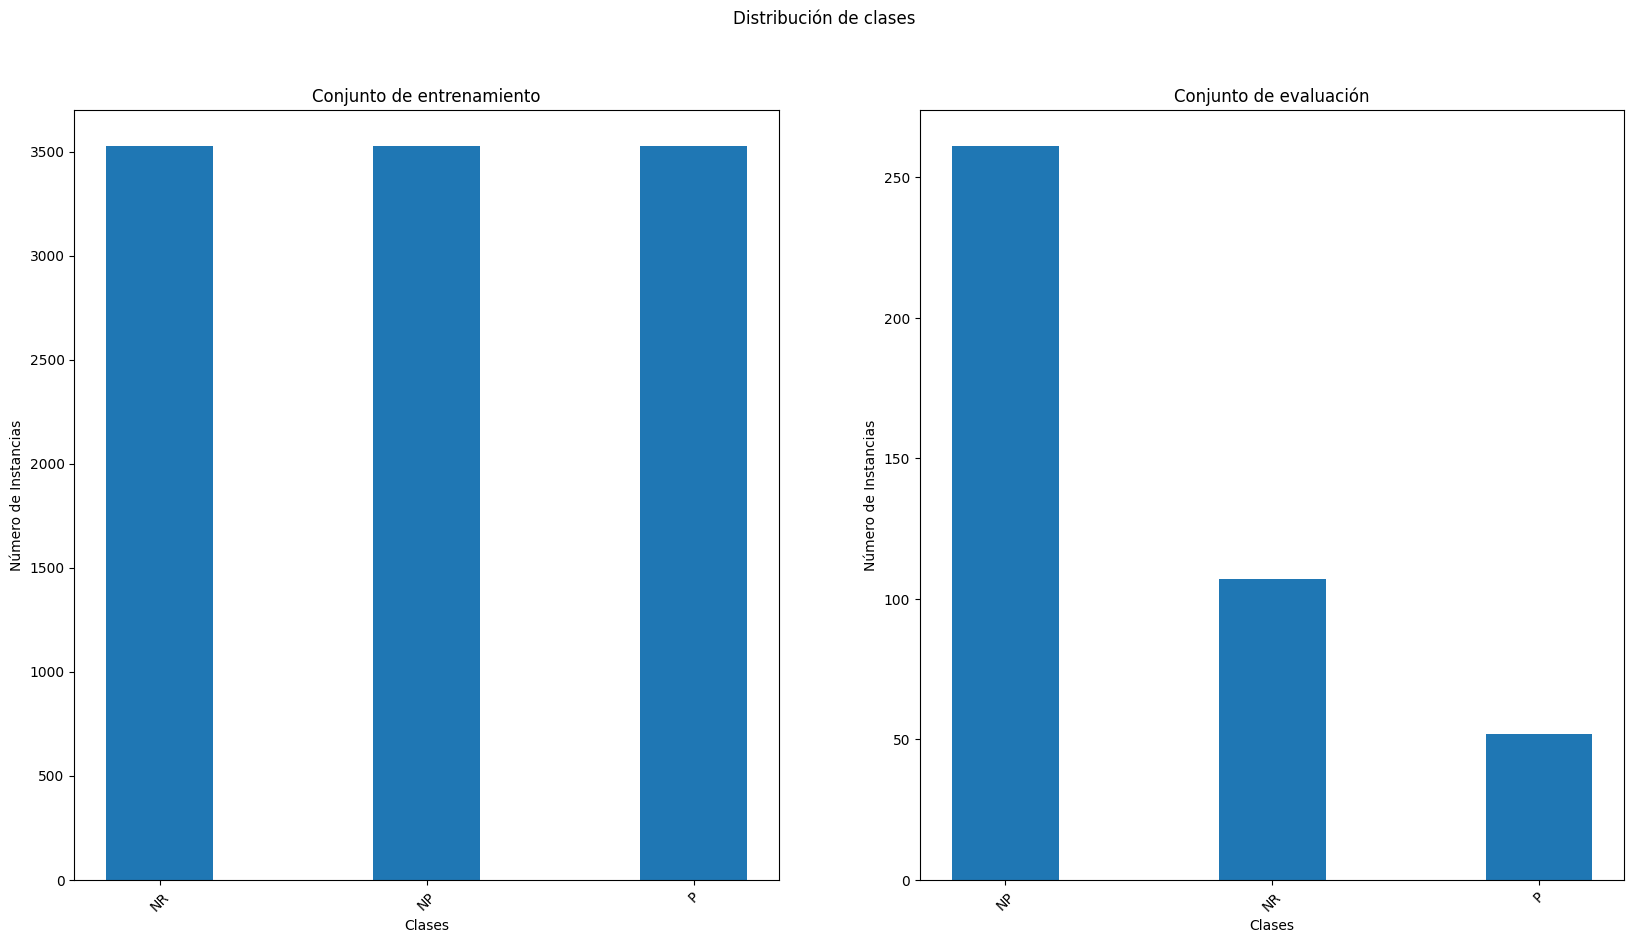

In [ ]:
import matplotlib.pyplot as plt

fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Distribución de clases')
ax_train.bar(list(counts_train.keys()), counts_train.values(), width=0.4)
ax_train.set_xticklabels(list(counts_train.keys()), rotation=45)

ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')

ax_test.bar(list(counts_test.keys()), counts_test.values(), width=0.4)
ax_test.set_xticklabels(list(counts_test.keys()), rotation=45)

ax_test.set_title('Conjunto de evaluación')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('Número de Instancias')

LABEL ENCODING

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = df_train['label'].tolist()
# print(NUM_LABELS)


y_test = df_test['label'].tolist()

le = LabelEncoder()

print("antes de transform: ", y_train[:10])
y_train = le.fit_transform(y_train)
print("labels:", le.classes_)
LABELS = le.classes_
NUM_LABELS = len(LABELS)

print("después de transform:", y_train[:10])
y_train_cat = to_categorical(y_train)
print("después de transform:", y_train_cat[:10])

y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)





antes de transform:  ['NR', 'NP', 'NR', 'NR', 'NR', 'NP', 'NP', 'NP', 'NR', 'NP']
labels: ['NP' 'NR' 'P']
después de transform: [1 0 1 1 1 0 0 0 1 0]
después de transform: [[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


REPRESENTACION DE TEXTO

In [ ]:
from keras.preprocessing.text import Tokenizer

X_train = df_train['content'].tolist()

tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))

Tamaño del vocabulario =23041


In [ ]:
from keras.utils import pad_sequences
MAX_LEN=45
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

Cargar el modelo de word embeddings

Crear Matriz de embeddings (estudiar eso)

CNN

In [ ]:
import tensorflow as tf
# asegurar que los experimentos se pueden reproducir
tf.random.set_seed(42)
tf.__version__

'2.15.0'

Crear el modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D


model = Sequential()
EMBEDDING_SIZE=300 #probar con 200, 300

### Esta es la única capa que se ve modificada
model.add(Embedding(NUM_WORDS,EMBEDDING_SIZE,input_length=MAX_LEN,))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# Capa BLSTM
model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.2)))

# Capa de aplanamiento
model.add(Flatten())

# Capas completamente conectadas
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 45, 300)           6912300   
                                                                 
 conv1d_42 (Conv1D)          (None, 45, 128)           153728    
                                                                 
 max_pooling1d_48 (MaxPooli  (None, 22, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_43 (Conv1D)          (None, 22, 64)            32832     
                                                                 
 max_pooling1d_49 (MaxPooli  (None, 11, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_44 (Conv1D)          (None, 11, 32)          

In [ ]:
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 45, 300)           6912300   
                                                                 
 conv1d_42 (Conv1D)          (None, 45, 128)           153728    
                                                                 
 max_pooling1d_48 (MaxPooli  (None, 22, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_43 (Conv1D)          (None, 22, 64)            32832     
                                                                 
 max_pooling1d_49 (MaxPooli  (None, 11, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_44 (Conv1D)          (None, 11, 32)          

Entrenar el modelo

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Para el entrenamiento después de 3 epochs sin el error en el conjunto de validación no mejora
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [ ]:
epochs = 10
batch_size = 16

# training
history=model.fit(encoded_train_pad,  # textos preprocesados
                  y_train_cat,          # labels en formato one-hot
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )


Epoch 1/10
529/529 [==============================] - 75s 129ms/step - loss: 0.9748 - accuracy: 0.4357 - val_loss: 1.1593 - val_accuracy: 0.0099
Epoch 2/10
529/529 [==============================] - 74s 139ms/step - loss: 0.8193 - accuracy: 0.5387 - val_loss: 0.9311 - val_accuracy: 0.9291
Epoch 3/10
529/529 [==============================] - 68s 129ms/step - loss: 0.7348 - accuracy: 0.6248 - val_loss: 0.5371 - val_accuracy: 0.9697
Epoch 4/10
529/529 [==============================] - 69s 131ms/step - loss: 0.5857 - accuracy: 0.8126 - val_loss: 0.4790 - val_accuracy: 0.9418
Epoch 5/10
529/529 [==============================] - 69s 131ms/step - loss: 0.3417 - accuracy: 0.9195 - val_loss: 0.3853 - val_accuracy: 0.9579
Epoch 6/10
529/529 [==============================] - 68s 128ms/step - loss: 0.2037 - accuracy: 0.9564 - val_loss: 0.2743 - val_accuracy: 0.9650
Epoch 7/10
529/529 [==============================] - 69s 130ms/step - loss: 0.1398 - accuracy: 0.9700 - val_loss: 0.2317 - val_ac

Curvas de aprendizaje


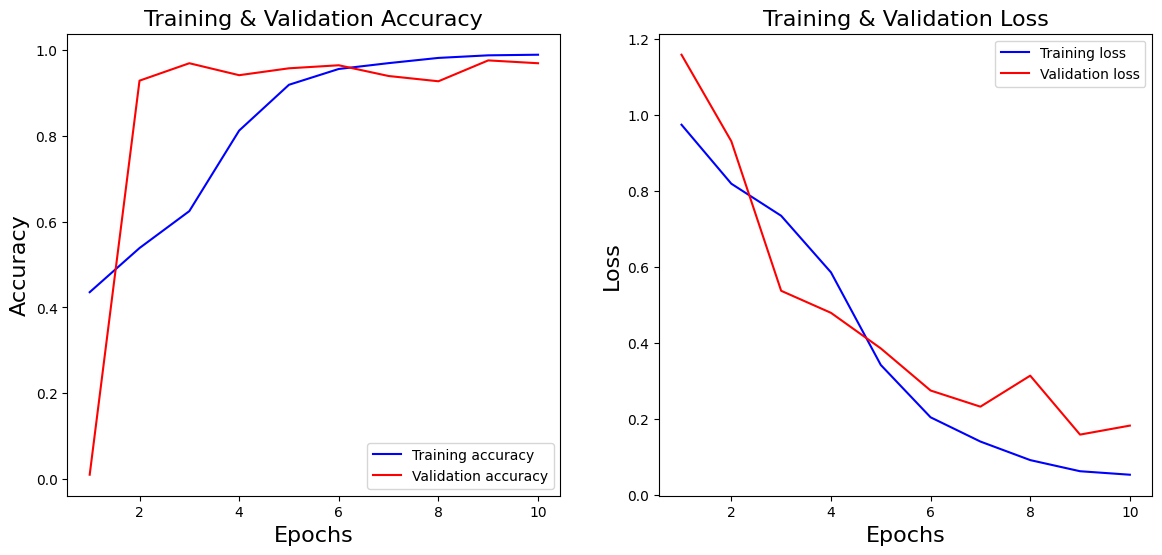

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Curva accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Curva loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Evaluar modelo

In [ ]:
X_test = df_test['content'].tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)

ValueError: Data cardinality is ambiguous:
  x sizes: 2200
  y sizes: 420
Make sure all arrays contain the same number of samples.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
y_pred = np.argmax(model.predict(encoded_test), axis=1)
print(y_pred[0:10])

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=LABELS))

14/14 [==============================] - 1s 18ms/step
[1 0 0 0 0 0 0 0 0 0]
accuracy: 0.8023809523809524
              precision    recall  f1-score   support

          NP       0.82      0.92      0.87       261
          NR       0.77      0.67      0.72       107
           P       0.74      0.50      0.60        52

    accuracy                           0.80       420
   macro avg       0.78      0.70      0.73       420
weighted avg       0.80      0.80      0.79       420



Resultados de la macro

[[239  14   8]
 [ 34  72   1]
 [ 18   8  26]]


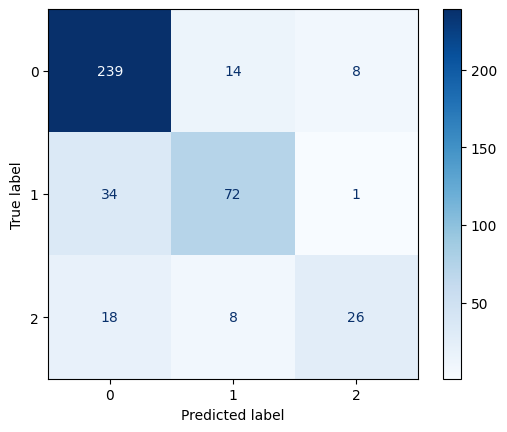

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

In [ ]:
df_test = pd.read_csv("track_1_public_test.csv",  sep=',')
X_test=df_test['content']

Test_predictions = model.predict(X_test)
# Crear un DataFrame con las columnas 'sub_id' y 'content' del DataFrame original
nuevo_data = df_test[['sub_id']].copy()

# Agregar la columna 'label' con los resultados de las predicciones
nuevo_data['label'] = Test_predictions
nuevo_data
nuevo_data.to_csv('track_1_predictions.csv', index=False)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 6642, in pool2d
        x = tf.compat.v1.nn.max_pool(

    ValueError: Exception encountered when calling layer 'max_pooling1d_18' (type MaxPooling1D).
    
    Negative dimension size caused by subtracting 2 from 1 for '{{node sequential_6/max_pooling1d_18/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](sequential_6/max_pooling1d_18/ExpandDims)' with input shapes: [?,1,1,128].
    
    Call arguments received by layer 'max_pooling1d_18' (type MaxPooling1D):
      • inputs=tf.Tensor(shape=(None, 1, 128), dtype=float32)
